<a href="https://colab.research.google.com/github/kimhwijin/korean_food_classifier/blob/master/korean_food_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip Dataset

In [1]:
import time

start = time.time()
!unzip -qq "drive/MyDrive/Datasets/kfood.zip"
end = time.time()
print((end-start) // 60, "분...")

6.0 분...


#Clone github

In [2]:
!git clone https://github.com/kimhwijin/korean_food_classifier.git

Cloning into 'korean_food_classifier'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 250 (delta 132), reused 199 (delta 85), pack-reused 0
Receiving objects: 100% (250/250), 8.97 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (132/132), done.


In [3]:
import sys
import os
sys.path.append(os.getcwd() + '/korean_food_classifier')

In [4]:
import kfood_dataset
batch_size = 32
paths = kfood_dataset.get_image_paths()

dataset path : /content/kfood True
making class to label txt file...
saving classes, labels...
saving crop information...
ready!
finding image paths...
shuffling...
paths ready!


# Imports

In [5]:
import tensorflow as tf
from tensorflow import keras

# Make Train, Valid, Test, Dataset

In [6]:
train_set = kfood_dataset.make_kfood_dataset(paths[30000:], n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=len(paths[30000:]) // batch_size)
valid_set = kfood_dataset.make_kfood_dataset(paths[20000:30000], n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=10000 // batch_size)
test_set = kfood_dataset.make_kfood_dataset(paths[:20000], n_parse_threads=tf.data.AUTOTUNE, batch_size=None)

# Plot samples

tf.Tensor([[16]], shape=(1, 1), dtype=int64)
tf.Tensor([[147]], shape=(1, 1), dtype=int64)
tf.Tensor([[61]], shape=(1, 1), dtype=int64)
tf.Tensor([[27]], shape=(1, 1), dtype=int64)


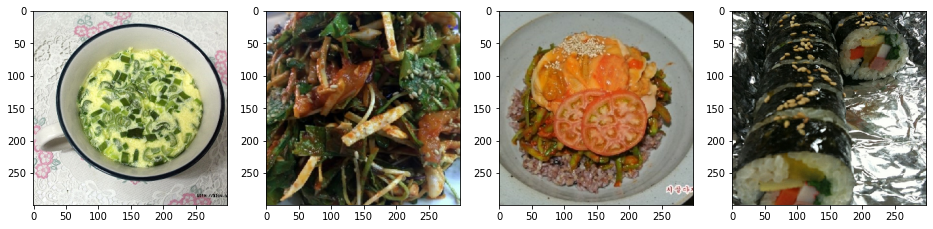

In [7]:
kfood_dataset.plot_dataset_image_4(train_set)

# Model Saver

In [21]:
import datetime
now = datetime.datetime.now()
model_name = 'PretrainedInceptionResNetV2'
model_paths = 'drive/MyDrive/Model/kfood/{}/'
if not os.path.exists(model_paths.format(model_name)):
    os.mkdir(model_paths.format(model_name))


class ModelSaver(keras.callbacks.Callback):
    def __init__(self, now, model_paths,**kwargs):
        self.now = now
        self.model_paths = model_paths

    def on_epoch_end(self, epoch, logs={}):
        fileformats = [self.now.year, self.now.month, self.now.day, self.now.hour, self.now.minute, epoch]
        self.model.save(self.model_paths + "{}_{}_{}_{}_{}_{}.hd5".format(*fileformats))

# Model Train With Pretrained Model

In [ ]:
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=[299,299,3])
avg = keras.layers.GlobalAvgPool2D()(base_model.output)
output = keras.layers.Dense(150, activation='softmax')(avg)

model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# BaseLayer Freeze

In [ ]:
# freeze
for layer in base_model.layers:
    layer.trainable = False

# Compile and Train

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=5)

Epoch 1/5
3765/3765 [==============================] - 789s 201ms/step - loss: 1.9645 - accuracy: 0.5206 - val_loss: 1.5937 - val_accuracy: 0.5800
Epoch 2/5
3765/3765 [==============================] - 751s 199ms/step - loss: 1.5099 - accuracy: 0.6019 - val_loss: 1.5502 - val_accuracy: 0.5931
Epoch 3/5
3765/3765 [==============================] - 753s 200ms/step - loss: 1.4439 - accuracy: 0.6198 - val_loss: 1.5046 - val_accuracy: 0.6044
Epoch 4/5
3765/3765 [==============================] - 750s 199ms/step - loss: 1.4117 - accuracy: 0.6307 - val_loss: 1.4977 - val_accuracy: 0.6137
Epoch 5/5
3765/3765 [==============================] - 754s 200ms/step - loss: 1.3901 - accuracy: 0.6347 - val_loss: 1.4925 - val_accuracy: 0.6098


In [ ]:
#save connacted pretrained and new model
now = datetime.datetime.now()
fileformats = [now.year, now.month, now.day, now.hour, now.minute]
model.save(model_paths + "stem_{}_{}_{}_{}_{}.hd5".format(*fileformats))

INFO:tensorflow:Assets written to: drive/MyDrive/Model/kfood/PretrainedInceptionResNetV2/stem_2022_1_31_9_40.hd5/assets


# Load Connected Weight Model

In [9]:
model = keras.models.load_model("/content/drive/MyDrive/Model/kfood/PretrainedInceptionResNetV2/stem_2022_1_31_9_40.hd5")

# Check Weights With Evaluate

In [ ]:
model.evaluate(valid_set, steps=10000 // 32)

312/312 [==============================] - 64s 191ms/step - loss: 1.4889 - accuracy: 0.6132


[1.4888681173324585, 0.6131811141967773]

# Release Layers

In [17]:
#release
for layer in model.layers[:-2]:
    layer.trainable = True

# Compile and Train

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [22]:
history = model.fit(train_set, steps_per_epoch=len(paths[30000:])//batch_size,
          validation_data=valid_set, validation_steps=10000 // batch_size, 
          epochs=40,
          callbacks=[ModelSaver(datetime.datetime.now(), model_paths.format(model_name))]
          )

Epoch 1/40
3765/3765 [==============================] - 2326s 606ms/step - loss: 0.7652 - accuracy: 0.7866 - val_loss: 0.6133 - val_accuracy: 0.8289
Epoch 2/40
3765/3765 [==============================] - 2285s 607ms/step - loss: 0.3556 - accuracy: 0.9014 - val_loss: 0.5375 - val_accuracy: 0.8478
Epoch 3/40
3765/3765 [==============================] - 2283s 606ms/step - loss: 0.2173 - accuracy: 0.9421 - val_loss: 0.5122 - val_accuracy: 0.8574
Epoch 4/40
3765/3765 [==============================] - 2294s 609ms/step - loss: 0.1462 - accuracy: 0.9643 - val_loss: 0.5131 - val_accuracy: 0.8607
Epoch 5/40
3765/3765 [==============================] - 2291s 609ms/step - loss: 0.1071 - accuracy: 0.9766 - val_loss: 0.5108 - val_accuracy: 0.8625
Epoch 6/40
3765/3765 [==============================] - 2284s 607ms/step - loss: 0.0840 - accuracy: 0.9833 - val_loss: 0.5136 - val_accuracy: 0.8622
Epoch 7/40
3765/3765 [==============================] - 2280s 606ms/step - loss: 0.0675 - accuracy: 0.9879

KeyboardInterrupt: ignored

In [23]:
from application.inception_resnet_v2 import InceptionResNetV2

inception = InceptionResNetV2()
inception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 stem_1 (Stem)               (None, 35, 35, 320)       441920    
                                                                 
 block35_10 (Block35)        (None, 35, 35, 320)       123408    
                                                                 
 block35_11 (Block35)        (None, 35, 35, 320)       123408    
                                                                 
 block35_12 (Block35)        (None, 35, 35, 320)       123408    
                                                                 
 block35_13 (Block35)        (None, 35, 35, 320)       123408    
                                                                 
 block35_14 (Block35)        (None, 35, 35, 320)       1234